# `bw_processing`: and now with `Apache` `parquet` files

* Author: Nikolaj van Omme
* Kernel: `conference`
* License: [CC-BY-SA-4.0](https://creativecommons.org/licenses/by-sa/4.0/)

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Info</b><br>
    <p style="color: black">
        This is still work in progress!
    </p>
<div>

## 1. What are Apache parquet files?

Apache `parquet` format allows to store matrices in column format, i.e. the matrices are stored column-wise and data can be stored or retrieved one (or several) column(s) at a time.

In fact, it is a *hybrid* mode:

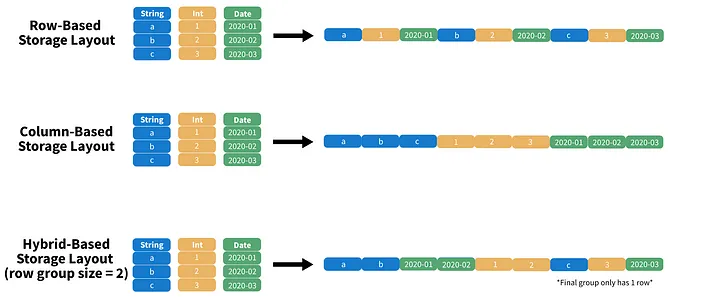

(Images from Michael Berk: https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705)

In short:
- since 2013
- main engine written in `java`
- column-wise compression is efficient in storage space
- encoding and compression techniques specific to the type of data in each column can be used
- queries that fetch specific column values need not read the entire row, thus improving performance

## 2. `parquet` files in `bw_processing`

**Main idea**: when serializing/deserializing vectors and matrices, you can use `numpy` `.npy` files or `parquet` `.parquet` files. You can even mix them together!

Each `Datapackage` can serialize/deserialize vectors and matrices in `.npy` or `.parquet` format. By default, the format is `.npy`. 
To switch from one or another, use an `Enum` `MatrixSerializeFormat`.

In [1]:
import bw_processing as bwp
[format.value for format in bwp.MatrixSerializeFormat]

['numpy', 'parquet']

For each operations that allows to serialize a matrix or vector, there is a `matrix_serialize_format_type` argument. 
If you want you can define a default value when creating a `Datapackage` object:

```Python 
dp = bwp.create_datapackage(..., matrix_serialize_format_type=bwp.MatrixSerializeFormat.PARQUET)
```
Now, every serialization will be done in `.parquet` format.

But you still can switch at any time to `.npy` format if you want:

```Python 
dp.add_persistent_vector(..., matrix_serialize_format_type=bwp.MatrixSerializeFormat.NUMPY)
```

By default, it will be in `.parquet` format:

```Python 
dp.add_persistent_vector(..., matrix_serialize_format_type=None)  # bwp.MatrixSerializeFormat.PARQUET
```


The format is encoded in the metadata provided by the `datapackage.json`:

```json
{
"resources": [
    {
      "profile": "data-resource",
      "format": "pqt",
      "mediatype": "application/octet-stream",
      "name": "some name.indices",
      "matrix": "some name",
      "kind": "indices",
      "path": "some name.indices.parquet",
      "group": "some name",
      "category": "vector",
      "nrows": 3
    }
    ]
}
```

which allows for an automatic deserialization!

## 3. First example with `OSFS`

Basic imports:

In [2]:
from fs.osfs import OSFS
import numpy as np
from pathlib import Path

Create some data:

In [3]:
indices_array = np.array([(0, 1), (1, 0), (1, 1)], dtype=bwp.INDICES_DTYPE)
data_array = np.array([1, 2, 3])
flip_array = np.array([True, False, False])

Create local directory to store the `Datapackage` object:

In [4]:
from base_fns import get_local_folder
dirpath = Path(get_local_folder())
dp_dir = OSFS(str(dirpath / "datapackage_1"), create=True)

Create `Datapackage` with default `.parquet` format to serialize the matrices and vectors:

In [5]:
dp = bwp.create_datapackage(fs=dp_dir, matrix_serialize_format_type=bwp.MatrixSerializeFormat.PARQUET)

Add some data:

In [6]:
dp.add_persistent_vector(
    matrix="some name",
    data_array=data_array,
    name="some name",
    indices_array=indices_array,
    flip_array=flip_array,
    keep_proxy=False
)

Finalize the serialization operation:

In [7]:
dp.finalize_serialization()

Try to load the `Datapackage` object:

In [8]:
dp_dir = OSFS(str(dirpath  / "datapackage_1"))  # need to re-open
dp2 = bwp.load_datapackage(fs_or_obj=dp_dir)
for k in dp2.resources:
    print(k)

{'profile': 'data-resource', 'format': 'pqt', 'mediatype': 'application/octet-stream', 'name': 'some name.indices', 'matrix': 'some name', 'kind': 'indices', 'path': 'some name.indices.parquet', 'group': 'some name', 'category': 'vector', 'nrows': 3}
{'profile': 'data-resource', 'format': 'pqt', 'mediatype': 'application/octet-stream', 'name': 'some name.data', 'matrix': 'some name', 'kind': 'data', 'path': 'some name.data.parquet', 'group': 'some name', 'category': 'vector', 'nrows': 3}
{'profile': 'data-resource', 'format': 'pqt', 'mediatype': 'application/octet-stream', 'name': 'some name.flip', 'matrix': 'some name', 'kind': 'flip', 'path': 'some name.flip.parquet', 'group': 'some name', 'category': 'vector', 'nrows': 3}


## 4. Second example with `ZipFS`

Basic imports:

In [9]:
from fs.zipfs import ZipFS

Create local zip file to store the Datapackage object:

In [10]:
dp_zip_file = ZipFS(str(dirpath / "datapackage_2.zip"), write=True)
dp = bwp.create_datapackage(fs=dp_zip_file)  # by default: .npy

Add some data:

In [11]:
dp.add_persistent_vector(
    matrix="some name",
    data_array=data_array,
    name="some name",
    indices_array=indices_array,
    flip_array=flip_array,
    keep_proxy=False
)

Add some data but this time in `.parquet` format:

In [12]:
dp.add_persistent_vector(
    matrix="some other name",
    data_array=data_array,
    name="some other name",
    indices_array=indices_array,
    flip_array=flip_array,
    keep_proxy=False,
    matrix_serialize_format_type=bwp.MatrixSerializeFormat.PARQUET
)

Finalize the serialization operation:

In [13]:
dp.finalize_serialization()

Try to load the `Datapackage` object:

In [14]:
dp_zip_file = ZipFS(str(dirpath / "datapackage_2.zip"))
dp2 = bwp.load_datapackage(fs_or_obj=dp_zip_file)

In [15]:
print(dp2.resources)

[{'profile': 'data-resource', 'format': 'npy', 'mediatype': 'application/octet-stream', 'name': 'some name.indices', 'matrix': 'some name', 'kind': 'indices', 'path': 'some name.indices.npy', 'group': 'some name', 'category': 'vector', 'nrows': 3}, {'profile': 'data-resource', 'format': 'npy', 'mediatype': 'application/octet-stream', 'name': 'some name.data', 'matrix': 'some name', 'kind': 'data', 'path': 'some name.data.npy', 'group': 'some name', 'category': 'vector', 'nrows': 3}, {'profile': 'data-resource', 'format': 'npy', 'mediatype': 'application/octet-stream', 'name': 'some name.flip', 'matrix': 'some name', 'kind': 'flip', 'path': 'some name.flip.npy', 'group': 'some name', 'category': 'vector', 'nrows': 3}, {'profile': 'data-resource', 'format': 'pqt', 'mediatype': 'application/octet-stream', 'name': 'some other name.indices', 'matrix': 'some other name', 'kind': 'indices', 'path': 'some other name.indices.parquet', 'group': 'some other name', 'category': 'vector', 'nrows': 3

In [16]:
print(len(dp2.resources))

6


## 5. Architectural choices

### 5.1 Why `pyarrow` and `pyarrow.parquet`?

Choice made because:
- there aren't many wrappers in `Python` (`pyarrow.parquet` vs `fastparquet`)
- `pyarrow.parquet` seems more stable 
- `pyarrow.parquet` is more complete

You don't have access to the low API in `Python`. The solution? Use `pyarrow.Table`!

```Python
import pyarrow as pa
import pyarrow.parquet as pq

schema = pa.schema(...)
table = pa.table(..., schema=schema)

file = ...

pq.write_table(table, file)
```

### 5.2 Internal formats

`nympy` arrays are stored with the **exact** same type and the serialization/deserialization operations produce **exactly** the same `numpy` arrays.

Vectors are stored as one column (so as the transposed row so to speak) in general except for the specialized cases:

- if `dtype=INDICES_DTYPE` (indices vectors), the row indices are stored in a `row` column and the column indices are stored in a `col` column;
- if `dtype=UNCERTAINTY_DTYPE` (distributions vectors), the seven columns are named as defined by the type:

        UNCERTAINTY_DTYPE = [
            ("uncertainty_type", np.uint8),
            ("loc", np.float32),
            ("scale", np.float32),
            ("shape", np.float32),
            ("minimum", np.float32),
            ("maximum", np.float32),
            ("negative", bool),
        ].

Matrices are stored by columns:
    
- the names of the colums are defined by the strings "0", "1", "2", and so on.